<a href="https://colab.research.google.com/github/prabinbohara10/Federated-Learning/blob/main/notebooks/FIFAI_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌟 Welcome to the FIFAI Summer Kaggle Competition! 🌟

This Jupyter notebook is your main point of entry for the FIFAI Summer Kaggle Competition 🌞. Here, you'll have the chance to apply the skills you've learned over the past few days in a practical, competitive environment. This notebook contains everything you need to get started:

- 📥 **Loading the Data**: Step-by-step instructions to load and preprocess the dataset.
- 🏢 **Setting Up the Federated Learning Environment**: Guidance on how to set up and run federated learning experiments.
- 📊 **Evaluation Metrics**: Tools to evaluate your models using various metrics.
- 🧠 **Simple Models**: Starter code for basic models to kickstart your experimentation.
- 📝 **Submission Files**: Code to help you generate and submit your results to Kaggle.

Dive in, explore, and have fun! We can't wait to see the innovative solutions you'll come up with. Good luck, and may the best model win! 🚀


# Setup

The following libraries are required to run this notebook. If you are running this on Colab it should be all smooth sailing. If you are running it locally please make sure you have all of these installed (take a look at the readme file at the [repo](https://github.com/RISE-MICCAI/FIFAI-Summer-School-2024/tree/main/Day%203%20-%20FIFAI%20Kaggle%20competition) for instructions on how to do this with conda).

In [1]:
import os
import random
import zipfile
from collections import defaultdict

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

from PIL import Image
import pandas as pd

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [2]:
torch.cuda.is_available()

False

In [ ]:
%pip install mlflow>=2.8.1
import mlflow
mlflow.set_experiment("FIFAI Kaagle Competition")

2024/07/26 15:25:44 INFO mlflow.tracking.fluent: Experiment with name 'FIFAI Kaagle Competition' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/934907595951877537', creation_time=1722007544372, experiment_id='934907595951877537', last_update_time=1722007544372, lifecycle_stage='active', name='FIFAI Kaagle Competition', tags={}>

# Dataloading

First thing we need to do is load in the data. We will be looking at the ChestMNIST dataset (a multi-label dataset from [MedMNIST](https://github.com/MedMNIST/MedMNIST)). This dataset looks at images of lungs that are healthy vs unhealthy for various diseases. We have taken a subset of this data and converted into a binary classification dataset. It consists of a training set with both images and labels and a test set with just images which you will use to make predictions and submit to Kaggle. Be sure to **download all** the files on the Kaggle site before proceeding with the next steps.





### Using Colab (skip if running locally)
The below is for use in a Colab notebook. Make a new folder called 'FIFAI_Kaggle' in your own Google Drive account. Simply upload everything into this 'FIFAI_Kaggle' folder. **NB** compress the images folder into a .zip file before uploading it otherwise it will take very long to upload. So upload 'images.zip', 'train.csv', 'test.csv', 'train_dataset.pkl' and 'test_dataset.pkl'. After that you can run the blocks of code below. First let's create a link to this new folder you created for ease of use.

In [6]:
# mount drive and create symlink
from google.colab import drive
drive.mount('/content/drive')
data_folder_name = 'FIFAI_Kaggle'
# make sure to check if this is the correct directory for your Google account some people do not have a space in 'My Drive'
!ln -s "/content/drive/My Drive/FIFAI_Kaggle" "/content/FIFAI_Kaggle" # NB when changing this

Mounted at /content/drive


Unzip the images zip file. This should take about 2-3 mins. **Do not** run it again if you have already unzipped the folder. No need to run this block if you are running this locally.

In [ ]:
# only run this once to unzip your files
import zipfile
import os

def unzip_folder(folder_path, extract_to=None):
    """
    Unzip the given folder.

    Parameters:
    folder_path (str): Path to the zipped folder.
    extract_to (str): Directory to extract files to. Defaults to the same directory as the zipped folder.

    Returns:
    None
    """
    if extract_to is None:
        extract_to = os.path.dirname(folder_path)

    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Extracted all files to {extract_to}')

# Example usage:
cwd = os.getcwd()
unzip_folder(os.path.join(cwd,data_folder_name,'images.zip'), extract_to = os.path.join(cwd,data_folder_name))


Extracted all files to /content/FIFAI_Kaggle


In [7]:
# data_folder_name = '/path_to_kaggle_files_on_local_dir' # uncomment and change this to the correct directory if running locally

# if you are running this locally make sure you change these directories appropriately
train_img_dir = os.path.join(data_folder_name, "images", "train")
test_img_dir = os.path.join(data_folder_name, "images", "test")
train_csv_path = os.path.join(data_folder_name,"train.csv")

Now we define appropriate classes and functions to help with dataloading when training our models.

In [8]:
# Create a PyTorch Dataset
class ChestMNISTDataset(Dataset):
    """
    This class is used to turn our dataset into a PyTorch-supported dataset.

    Parameters:
    - images: The images array from the MedMNIST dataset.
    - labels: The corresponding labels array for each image.
    - transform: Optional transformation to be applied to the images.
    """
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx])
        if self.transform:
            image = self.transform(image)
        return image, label


  # build dataset function which takes in Dataset class, img_directory and labels to generate the appropriate Dataset
def build_train_dataset(img_dir, img2label, transform=None):
    # run through img directory store images as np.array in images array. Simultaneously store labels in numpy array, using img2label. Then convert labels to tensor (or you can do this in the Dataset class).
    print('---------- Building Training Dataset ----------')
    # print('...')
    images = []
    labels = []
    total_images = len(img2label)
    step = total_images // 10  # 10% step

    for i, img_fname in enumerate(img2label):
        img_path = os.path.join(img_dir, img_fname)
        img = np.array(Image.open(img_path))
        label = img2label[img_fname]
        images.append(img)
        labels.append(label)

        # Print progress
        if (i + 1) % step == 0:
            progress = (i + 1) // step * 10
            print(f'{"-" * (progress // 10)} {progress}% complete')

    print('---------- Finished Training Dataset ----------')
    print()
    return ChestMNISTDataset(images, labels, transform=transform)


In [9]:
train_df = pd.read_csv(train_csv_path)
train_df

,ID,label
0,image_000000.png,0
1,image_000001.png,0
2,image_000002.png,0
3,image_000003.png,0
4,image_000004.png,0
...,...,...
6270,image_006270.png,1
6271,image_006271.png,1
6272,image_006272.png,1
6273,image_006273.png,1


In [10]:
train_df = pd.read_csv(train_csv_path) # get the csv containing the labels for the training data
img2label = {} # build a dictionary to help us associate each image with the appropriate label
for i in range(len(train_df['ID'])):
  img2label[train_df['ID'][i]] = train_df['label'][i]

#img2label

In [ ]:
# set a seed DO NOT change this
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# preprocessing (transforms we will apply to our images)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = build_train_dataset(train_img_dir, img2label, transform = data_transform)

---------- Building Training Dataset ----------
- 10% complete
-- 20% complete
--- 30% complete
---- 40% complete
----- 50% complete
------ 60% complete
------- 70% complete
-------- 80% complete
--------- 90% complete
---------- 100% complete
---------- Finished Training Dataset ----------



# Federated Learning

In this competition, we will be dealing with a specialised form of machine learning called *federated learning* which you should have heard a *little* bit about in the days prior. To do this we will simulate a federated learning setup right here in this notebook using some simple classes and functions. These were designed to be very easy to use so during the competition you will not need to change much in this setup. It works by having Client objects who will act as our nodes which we will train on locally, and a Server object which acts as our centralised server containing the global model. The aggregation strategy will be fixed here to **FedAvg** for simplicity.

Quick reminder, the equation for **FedAvg** [1] is the following:

 $$w^{t+1} = \dfrac{1}{n}\sum_{k=1}^{K} w_{k}^{t+1}$$

Each term represents:
* $w^{t+1}$: Updated global model parameters after round $t$.
* $n$: Total number of clients.
* $w_{k}^{t+1}$: Updated model parameters from client $k$ after local training.

When sending the model from the Server to the Client we will do a local average instead of overwriting the local model weights (with the global model) to preserve local structure in the local models at the respective Clients (take a look at 'send_with_local_ave' within the Server class).

In [27]:
client_weights = []
client_weights.append(clients[0].model.state_dict())

In [37]:
client_weights[0].keys()

odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'conv4.weight', 'conv4.bias', 'bn4.weight', 'bn4.bias', 'bn4.running_mean', 'bn4.running_var', 'bn4.num_batches_tracked', 'conv_layers.0.weight', 'conv_layers.0.bias', 'conv_layers.1.weight', 'conv_layers.1.bias', 'conv_layers.1.running_mean', 'conv_layers.1.running_var', 'conv_layers.1.num_batches_tracked', 'conv_layers.4.weight', 'conv_layers.4.bias', 'conv_layers.5.weight', 'conv_layers.5.bias', 'conv_layers.5.running_mean', 'conv_layers.5.running_var', 'conv_layers.5.num_batches_tracked', 'conv_layers.8.weight', 'conv_layers.8.bias', 'conv_layers.9.weight', 'conv_layers.9.bias', 'conv_layers.9.running_mean', 'c

In [38]:
import torch
from torch.utils.data import DataLoader


class Client:
    """
    A class representing a client in a federated learning setup.

    Attributes:
    - device: The device on which the client's model and data will be loaded (CPU or CUDA).
    - model: The initial model assigned to the client.
    - data: The dataset assigned to the client.
    - id: A unique identifier for the client.
    """
    def __init__(self, initial_model, data, id):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = initial_model.to(self.device)
        self.data = data
        self.id = id

    def get_model_params(self):
        """
        Returns the state dictionary of the client's model.

        Returns:
        - state_dict: The state dictionary of the client's model.
        """
        return self.model.state_dict()


class Server:
    """
    A class representing a central server in a federated learning setup.

    Attributes:
    - device: The device on which the server's global model will be loaded (CPU or CUDA).
    - global_model: The global model maintained by the server.
    - send_funcs: A dictionary mapping boolean flags to the corresponding send functions.
    - send: The send function to be used (with or without local averaging) mimicking sending of weights from server to client.
    """
    def __init__(self, model, local_weight_ave=True):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.global_model = model.to(self.device)
        self.send_funcs = {
            True: self.send_with_local_ave,
            False: self.send_without_local_ave
        }
        self.send = self.send_funcs[local_weight_ave]

    def send_without_local_ave(self, client):
        """
        Sends the global model to the client without local averaging.

        Parameters:
        - client: The client to which the global model will be sent.
        """
        client.model.load_state_dict(self.global_model.state_dict())
        print(f"Sent model to Client {client.id}")

    def send_with_local_ave(self, client):
        """
        Sends the global model to the client with local averaging.

        Parameters:
        - client: The client to which the averaged model will be sent.
        """
        global_params = self.global_model.state_dict()
        local_params = client.get_model_params()
        averaged_params = {key: (global_params[key] + local_params[key]) / 2 for key in global_params.keys()}
        client.model.load_state_dict(averaged_params)
        print(f"Sent model to Client {client.id}")

    def train(self, clients, gen_optimizer, loss_fn, num_epochs, batch_size=8, shuffle=True, lr=0.01):
        """
        Trains the global model using data from multiple clients.

        Parameters:
        - clients: A list of Client objects.
        - gen_optimizer: The optimizer generator function (basically a wrapper of a PyTorch optimiser object).
        - loss_fn: The loss function to be used for training.
        - num_epochs: The number of epochs for training.
        - batch_size: The batch size for data loading (default is 8).
        - shuffle: Whether to shuffle the data (default is True).
        - lr: Learning rate for the optimizer (default is 0.01).
        """
        client_weights = []
        for client in clients:
            self.send(client)
            data_loader = DataLoader(client.data, batch_size=batch_size, shuffle=shuffle)
            optimizer = gen_optimizer(params=client.model.parameters(), lr=lr)
            client.model.train()
            print(f'Begin local training at Client {client.id}')
            for epoch in range(num_epochs):
                losses = []
                for data, target in data_loader:
                    data, target = data.to(self.device), target.to(self.device)
                    optimizer.zero_grad()
                    # print(f"loaded data")
                    output = client.model(data)
                    loss = loss_fn(output, target)
                    loss.backward()
                    optimizer.step()
                    losses.append(loss.clone().detach())
                ave_loss = torch.mean(torch.tensor(losses))
                print(f'Training loss, running average over batches, at end of epoch {epoch} is {ave_loss}')
            print(f'End of local training at Client {client.id}')
            client_weights.append(client.get_model_params())
            print('------------------------------------------------------------------')

        avg_model_params = self.aggregate_weights(client_weights)
        self.global_model.load_state_dict(avg_model_params)

    def aggregate_weights(self, client_weights):
        """
        Aggregates the weights from multiple clients using simple averaging.

        Parameters:
        - client_weights: A list of state dictionaries from clients.

        Returns:
        - avg_params: The averaged state dictionary.
        """
        avg_params = {key: torch.zeros_like(param, dtype = torch.float32) for key, param in client_weights[0].items()}
        for params in client_weights:
            for key in params.keys():
                avg_params[key] += params[key] / len(client_weights)
        return avg_params

    # need a nice test function here that incorporates all of your "FAIR" metrics
    # def test(self, validation_dataset, batch_size=64, device=None):


def setup_federated_simulation_env(model, client_names, dataset, data_weights, local_weight_ave=True):
    """
    Sets up the federated learning simulation environment.

    Parameters:
    - model: The initial global model.
    - client_names: A list of names for the clients.
    - dataset: The dataset to be split among the clients.
    - data_weights: A list of weights specifying the proportion of data for each client.
    - local_weight_ave: A boolean flag indicating whether to use local weight averaging (default is True).

    Returns:
    - central_server: The Server object.
    - clients: A list of Client objects.
    """
    print('---------- Setting up Federating Learning Environment ----------')
    print('...')
    central_server = Server(model, local_weight_ave=local_weight_ave)
    if len(client_names) != len(data_weights):
        raise ValueError("Number of clients does not match proposed data splitting given data weights.")
    subset_datasets = split_dataset(dataset, data_weights)
    clients = [Client(model, subset_dataset, client_name) for client_name, subset_dataset in zip(client_names, subset_datasets)]
    print('---------- Finished Setting up Federating Learning Environment ----------')
    print()
    return central_server, clients



# helper function to split the datasets
import numpy as np
from torch.utils.data import Subset

def split_dataset(dataset, data_weights):
    """
    Splits a dataset into multiple subsets according to specified weights.

    Parameters:
    - dataset: The original dataset to be split.
    - data_weights: A list of weights specifying the proportion of each subset.
                    The sum of data_weights should be 1.

    Returns:
    - A list of dataset objects, each corresponding to a subset of the original dataset.
    """
    if not np.isclose(np.sum(data_weights), 1):
      raise ValueError('Invalid data_weights, do not sum to 1.')
    total_samples = len(dataset)
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    split_indices = []
    current_idx = 0
    for weight in data_weights:
        split_size = int(np.floor(weight * total_samples))
        split_indices.append(indices[current_idx:current_idx + split_size])
        current_idx += split_size

    # Ensure that all samples are included (add the remaining samples to the last subset)
    if current_idx < total_samples:
        split_indices[-1] = np.concatenate((split_indices[-1], indices[current_idx:]), axis=0)

    # Create the subset datasets
    subset_datasets = [Subset(dataset, indices) for indices in split_indices]

    return subset_datasets

The Federated setup is designed such that the only "things" to vary is the model, the optimiser and the loss function. When we eventually get to the training run it will be clear how to do this but before that let's define some basic models to use.

Here we have included some very simple models that you can start off with.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=28*28*1, hidden_dim=128, output_dim=2):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

# Logistic Regression
class LogisticRegressor(nn.Module):
    def __init__(self, input_dim=28*28*1, output_dim=2):
        super(LogisticRegressor, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        out = self.fc(x)
        return out


# SimpleCNN architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7) # this flattens the tensor for FC layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

import torch
import torch.nn as nn

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for the first layer
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for the second layer
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for the third layer
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch normalization for the fourth layer
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability
        # Calculate the input size for the first fully connected layer
        self._to_linear = None
        self.conv_layers = nn.Sequential(
            self.conv1, self.bn1, nn.ReLU(), self.pool,
            self.conv2, self.bn2, nn.ReLU(), self.pool,
            self.conv3, self.bn3, nn.ReLU(), self.pool,
            self.conv4, self.bn4, nn.ReLU(), self.pool
        )
        self._get_conv_output_size()
        # First fully connected layer
        self.fc1 = nn.Linear(in_features=self._to_linear, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)
        # ReLU activation
        self.relu = nn.ReLU()

    def _get_conv_output_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)  # Assuming input image size is 28x28
            x = self.conv_layers(x)
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = EnhancedCNN(num_classes=2)
print(model)

EnhancedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Let's initialize our Federated Learning simulation and perform a demo training run to see how it all works together. Pay attention particularly to the 'gen_optimizer' and the 'criterion' functions. In our simulation, we are training locally, and because some optimizers, like Adam, leverage features like gradient history, we need to initialize our optimizers at the Client. To achieve this, we generate the optimizer locally when we train, which is slightly different from simply feeding in a PyTorch optimizer.

Instead of re-building the dataset everytime, we will just load in a pre-pickled Python object.

In [13]:
import pickle

# load in our pickled dataset
with open(os.path.join(data_folder_name, "train_dataset.pkl"), 'rb') as f:
    train_dataset = pickle.load(f)

In [41]:
# set a seed DO NOT change this
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = EnhancedCNN()
global_model = model


client_names = ['Hospital 1', 'Hospital 2','Hospital 3', 'Hospital 4']
data_weights = [0.25, 0.25, 0.25, 0.25]
server, clients =  setup_federated_simulation_env(model = global_model, client_names = client_names, dataset = train_dataset, data_weights = data_weights, local_weight_ave = True)

# Define optimizer and loss function
def gen_optimizer(params, lr):
    return torch.optim.SGD(params=params, lr=lr)

def criterion(input, target):
  loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn(input, target)

# Train using Federated Averaging
server.train(clients, gen_optimizer, loss_fn = criterion, num_epochs=50, lr = 0.001) # can quickly see the effect of a large learning rate

---------- Setting up Federating Learning Environment ----------
...
---------- Finished Setting up Federating Learning Environment ----------

Sent model to Client Hospital 1
Begin local training at Client Hospital 1
Training loss, running average over batches, at end of epoch 0 is 0.5299230813980103
Training loss, running average over batches, at end of epoch 1 is 0.5101958513259888
Training loss, running average over batches, at end of epoch 2 is 0.5048909187316895
Training loss, running average over batches, at end of epoch 3 is 0.49474209547042847
Training loss, running average over batches, at end of epoch 4 is 0.49442461133003235
Training loss, running average over batches, at end of epoch 5 is 0.48655304312705994
Training loss, running average over batches, at end of epoch 6 is 0.4819793999195099
Training loss, running average over batches, at end of epoch 7 is 0.47890689969062805
Training loss, running average over batches, at end of epoch 8 is 0.4740433692932129
Training loss

# 📊 Evaluation

A focus of this competition is to learn about different metrics that are used in classification, to try mitigate bias or imbalances in data. Lets look at some more "conventional" metrics first.

When evaluating the performance of a binary classification model, several metrics are commonly used. Below, we explain and provide the formulas for some of these key metrics: Accuracy, Confusion Matrix, Sensitivity, and Specificity.

## 1. Accuracy

**Accuracy** is the ratio of correctly predicted instances to the total instances. It is a measure of the overall effectiveness of the classifier.

**Formula:**

$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

Where:
- \( TP \) = True Positives
- \( TN \) = True Negatives
- \( FP \) = False Positives
- \( FN \) = False Negatives

## 2. Confusion Matrix

A **Confusion Matrix** is a table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.


\begin{array}{c|c|c}
\text{Actual / Predicted} & \text{Positive} & \text{Negative} \\
\hline
\text{Positive} & TP & FN \\
\text{Negative} & FP & TN \\
\end{array}


## 3. Sensitivity (Recall)

**Sensitivity**, also known as **Recall**, measures the proportion of actual positives that are correctly identified by the model. It focuses on the ability of the classifier to find all the positive samples.

**Formula:**


$$ \text{Sensitivity} = \frac{TP}{TP + FN} $$


## 4. Specificity

**Specificity** measures the proportion of actual negatives that are correctly identified by the model. It focuses on the ability of the classifier to find all the negative samples.

**Formula:**


$$ \text{Specificity} = \frac{TN}{TN + FP} $$


## Summary

These metrics help in understanding the performance of a binary classification model from different perspectives. While accuracy gives a general measure of performance, the confusion matrix provides a detailed breakdown, and sensitivity and specificity offer insights into how well the model performs on the positive and negative classes, respectively.


In [42]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

def get_accuracy(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes overall accuracy for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 128).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - overall_accuracy: The overall accuracy over the entire dataset.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    # Compute overall accuracy
    overall_accuracy = (all_outputs.argmax(dim=1) == all_targets).float().mean().item()

    return overall_accuracy

def get_confusion_matrix(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes and displays the confusion matrix for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 64).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - cm: Confusion matrix
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Predicting Disease')
    plt.show()

    return cm

def get_sensitivity(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes the sensitivity metric for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 1228).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - sensitivity: The sensitivity metric.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Extract True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    return sensitivity

def get_specificity(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes the specificity metric for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 1228).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - specificity: The specificity metric.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)
    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Extract True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    return specificity


Lets test this on one of our clients data.

In [43]:
# lets get the accuracy
client0_data_accuracy = get_accuracy(clients[0].data, server.global_model)
client1_data_accuracy = get_accuracy(clients[1].data, server.global_model)
client2_data_accuracy = get_accuracy(clients[2].data, server.global_model)
client3_data_accuracy = get_accuracy(clients[3].data, server.global_model)
print(client0_data_accuracy, client1_data_accuracy, client2_data_accuracy, client3_data_accuracy)

0.769132673740387 0.7818877696990967 0.8335459232330322 1.0


We have only trained our model for 5 epochs but we are already getting 79\% accuracy. It appears that this is a fairly easy problem for us but before we simply run a few more epochs and close shop let's take a closer look by observing the 'confusion matrix'.

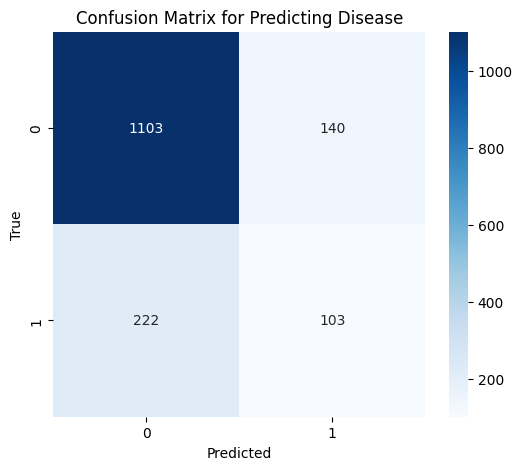

array([[1103,  140],
       [ 222,  103]])

In [44]:
get_confusion_matrix(clients[0].data, clients[0].model)

This paints a clearer picture, even though our accuracy is high we can see that this is just a consequence of an imbalance in the data. You can see we do not predict a single diseased example of a lung correctly. The model is simply guessing "healthy" for every single sample (corresponding to a negative prediction for us). This is a common problem with metrics such as accuracy for data which is highly imbalanced. Let's take a look at the specificity and sensitivity metrics next.

In [45]:
specificity = get_specificity(clients[0].data, clients[0].model)
sensitivity = get_sensitivity(clients[0].data, clients[0].model)

print(f'The specificity for {clients[0].id} is {specificity}')
print(f'The sensitivity for {clients[0].id} is {sensitivity}')

The specificity for Hospital 1 is 0.8873692679002414
The sensitivity for Hospital 1 is 0.3169230769230769


In [46]:
client0_specificity = get_specificity(clients[0].data, server.global_model)
client1_specificity = get_specificity(clients[1].data, server.global_model)
client2_specificity = get_specificity(clients[2].data, server.global_model)
client3_specificity = get_specificity(clients[3].data, server.global_model)

client0_sensitivity = get_sensitivity(clients[0].data, server.global_model)
client1_sensitivity = get_sensitivity(clients[1].data, server.global_model)
client2_sensitivity = get_sensitivity(clients[2].data, server.global_model)
client3_sensitivity = get_sensitivity(clients[3].data, server.global_model)


print(client0_specificity, client1_specificity, client2_specificity, client3_specificity)
print(client0_sensitivity, client1_sensitivity, client2_sensitivity, client3_sensitivity)

0.8873692679002414 0.9021310181531176 0.9253968253968254 1.0
0.3169230769230769 0.2757475083056478 0.4577922077922078 1.0


If you look up at the definitions this makes sense. Specificity is how many negative samples of the total number of negative samples we capture which is everything because our model simply predicts negative for everythig. Sensitivity takes a look at how many positive samples of the total positive samples we are able to capture. Idealy we would like some metrics that are able to account for these imbalances in a single metric.

Let's introduce some new measures that are more robust and can better account for imbalances in data. These metrics and more recommendations can be found in this detailed Nature article [2].

## 5. Balanced Accuracy

**Balanced Accuracy** is the average of sensitivity and specificity. It is useful when the classes are imbalanced.

**Formula:**


$$ \text{Balanced Accuracy} = \frac{\text{Sensitivity} + \text{Specificity}}{2} $$

## 6. Area Under the Receiver Operating Characteristic Curve (AUROC)

**AUROC** is a performance measurement for classification problems at various threshold settings. ROC is a probability curve, and AUROC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

### Receiver Operating Characteristic (ROC) Curve

The **ROC Curve** is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity) at various threshold settings (a threshold being a probablility value above which we consider a sample to belong to a certain class). It shows the trade-off between sensitivity and specificity.

- **True Positive Rate (TPR)**: Same as Sensitivity
- **False Positive Rate (FPR)**: $$ \text{FPR} = \frac{FP}{FP + TN} $$

Each point on the curve corresponds to a FPR vs TPR for given probablity threshold [3].

ROCCurve.svg




**AUROC** is the area under the ROC curve. The higher the AUROC, the better the model is at distinguishing between the positive and negative classes with perfect value of AUROC is 1. I know it can be quite tricky to grasp this concept if it is the first time you are seeing it. I would recommend reading this [blog](https://mlu-explain.github.io/roc-auc/) [4] which gives a pretty good explanation. It will also be more evident when looking at some concrete examples.


## Summary 2

 Balanced accuracy and AUROC are metrics that are better adapted to dealing with imbalanced data. Balanced accuracy directly tackles the imbalance by averaging specificity and sensisitivity whilst AUROC assesses the model's overall ability to distinguish between classes i.e. how well it "ranks" the probabilities.


Let's take a look at an example

In [47]:
def get_balanced_accuracy(validation_dataset, model, batch_size=128, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Computes the balanced accuracy for the given model on the validation dataset.

    Parameters:
    - validation_dataset: The MedMNIST validation dataset.
    - model: The PyTorch model to be evaluated.
    - batch_size: Batch size for DataLoader (default is 1228).
    - device: The device to run the evaluation on (default is CUDA if available).

    Returns:
    - balanced_accuracy: The average balanced accuracy over all classes.
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Create DataLoader for validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_outputs = torch.cat(all_outputs)
    all_targets = torch.cat(all_targets)

    binarized_targets = (all_targets == 1).to(torch.int)
    binarized_preds = (all_outputs.argmax(dim=1) == 1).to(torch.int)
    cm = confusion_matrix(binarized_targets, binarized_preds)

    # Extract True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    balanced_acc = (sensitivity + specificity) / 2


    # balanced_accuracy = sum(class_balanced_accuracies) / num_classes
    return balanced_acc

# NB change the doc string here because you are no longer doing multi-class
def get_auroc_plot_roc(validation_dataset, model, batch_size=128, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    Calculate the AUROC and plot the ROC curve for a binary classification problem.

    Parameters:
    validation_dataset (Dataset): The validation dataset.
    model (nn.Module): The trained model.
    batch_size (int): The batch size for data loading.
    device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
    roc_auc: AUROC value.
    """
    # Set the model to evaluation mode
    model.eval()

    # Create a DataLoader for the validation dataset
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    # Lists to store true labels and predicted probabilities
    all_labels = []
    all_probs = []

    # Disable gradient calculation for validation
    with torch.no_grad():
        for batch in val_loader:
            # Move batch to the specified device
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs (logits)
            logits = model(inputs)

            # Apply softmax to get probabilities
            probabilities = F.softmax(logits, dim=1)

            # Store labels and probabilities
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy())

    # Concatenate all batches
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    all_probs = all_probs[:,1] # you need to only look at a single class for this metric


    # Calculate ROC curve and AUROC

    plt.figure(figsize=(12, 8))
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f' ROC model predictor (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label = 'ROC random predictor (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    return roc_auc

In [48]:
get_balanced_accuracy(clients[0].data, clients[0].model)

0.6021461724116591

In [49]:
client0_balanced_accuracy = get_balanced_accuracy(clients[0].data, server.global_model)
client1_balanced_accuracy = get_balanced_accuracy(clients[1].data, server.global_model)
client2_balanced_accuracy = get_balanced_accuracy(clients[2].data, server.global_model)
client3_balanced_accuracy = get_balanced_accuracy(clients[3].data, server.global_model)
print(client0_balanced_accuracy, client1_balanced_accuracy, client2_balanced_accuracy, client3_balanced_accuracy)

0.6021461724116591 0.5889392632293827 0.6915945165945167 1.0


This is a much more reasonable metric, which reflects a "truer" performance of our model for our purposes. It is very easy to intuitivley see how we get this value. We get 100\% of the negative label healthy samples but 0\% of the positive label unhealthy samples so we are left with an average performance of 50\%.

Now let's take a look at the ROC curve and the Area under this curve.

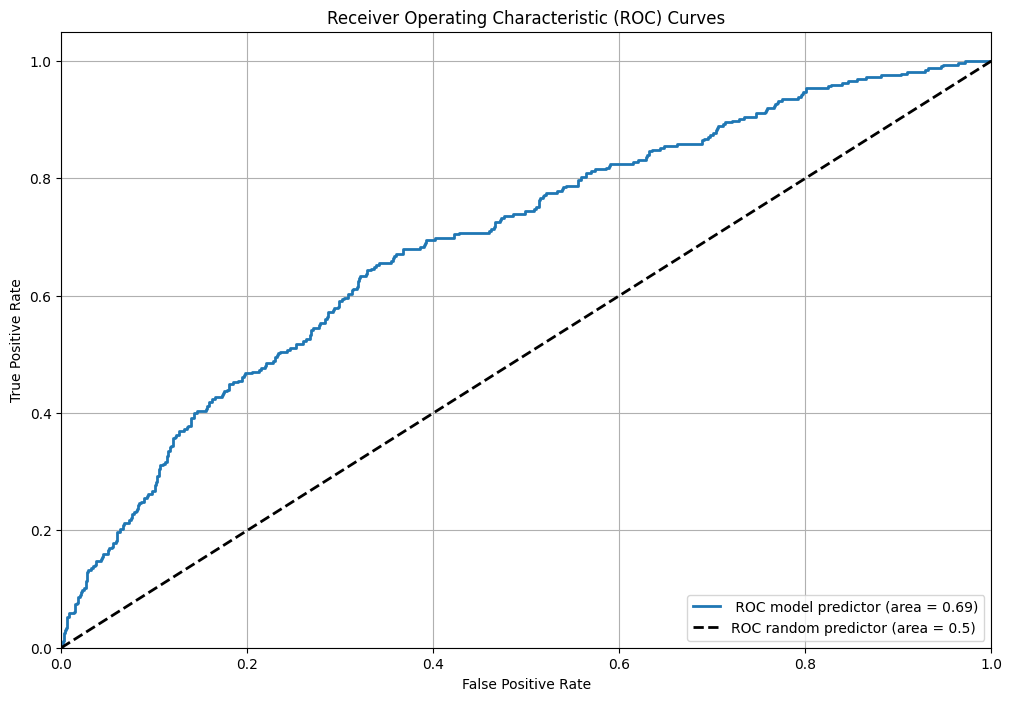

0.694679126183551

In [50]:
get_auroc_plot_roc(clients[0].data, clients[0].model)

This also appears to give us a more "sane" performance metric as 0.60 is considerably less that the previous 0.79 we were getting with just accuracy.  

Feel free to use these functions to help you assess the performance of your model as you make submissions to help guide you along your fine-tuning process.

In [ ]:
with mlflow.start_run() as run:
  print("Logging Pytorch Model")
  mlflow.pytorch.log_model(
      server.global_model, "pytorch-model", registered_model_name = "SimpleCNN"
  )
  model_uri = "runs:/{}/pytorch-model".format(run.info.run_id)
  print("Model saved in run %s" % run.info.run_id)
  print(f"Model URI : {model_uri}")

2024/07/26 15:35:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Logging Pytorch Model


2024/07/26 15:35:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Model saved in run dd028996818c4695aedb158025ed004c
Model URI : runs:/dd028996818c4695aedb158025ed004c/pytorch-model


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'SimpleCNN'.
Created version '1' of model 'SimpleCNN'.


# Kaggle Submission

Finally we need to create a submission for our Kaggle competition which will be a csv file containing the predictions of our test images. We first define some classes and functions to help with this.

In [51]:
# from inspect import isgetsetdescriptor
# Create a PyTorch Dataset
class ChestMNISTDatasetTest(Dataset):
    """
    This class is used to turn our dataset into a PyTorch-supported dataset.

    Parameters:
    - images: The images array from the MedMNIST dataset.
    - labels: The corresponding labels array for each image.
    - transform: Optional transformation to be applied to the images.
    """
    def __init__(self, images, ids, transform=None):
        self.images = images
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        id = self.ids[idx]
        if self.transform:
            image = self.transform(image)
        return image, id

def build_test_dataset(img_dir, transform=None):
    # run through img directory store images as np.array in images array. Simultaneously store labels in numpy array, using img2label. Then convert labels to tensor (or you can do this in the Dataset class).
    print('---------- Building Test Dataset ----------')
    images = []
    ids = []
    img_fnames = os.listdir(img_dir)
    total_images = len(img_fnames)
    step = total_images // 10  # 10% step

    for i, img_fname in enumerate(img_fnames):
        img_path = os.path.join(img_dir, img_fname)
        img = np.array(Image.open(img_path))
        id = img_fname
        images.append(img)
        ids.append(id)

        # Print progress
        if (i + 1) % step == 0:
            progress = (i + 1) // step * 10
            print(f'{"-" * (progress // 10)} {progress}% complete ')

    print('---------- Finished Building Test Dataset ----------')
    print()
    return ChestMNISTDatasetTest(images, ids, transform=transform)

import torch
from torch.utils.data import DataLoader
import pandas as pd


def gen_test_df(global_model, test_dataset, device, batch_size=32):
    # Set the model to evaluation mode
    global_model.eval()

    # Create a DataLoader for the test dataset
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Lists to store ids and predicted labels
    all_ids = []
    all_outputs = []

    total_batches = len(test_loader)
    step = total_batches // 10  # 10% step

    # Disable gradient calculation for evaluation
    print('---------- Inference on Test Dataset ----------')
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            # Move batch to the specified device
            inputs, input_ids = batch
            inputs = inputs.to(device)

            # Get model outputs (logits)
            logits = global_model(inputs)

            # Get the predicted labels
            predicted_labels = logits.argmax(dim=1).cpu().numpy()

            # Append ids and outputs to lists
            all_ids.extend(list(input_ids))
            all_outputs.extend(predicted_labels)

            # Print progress
            if (i + 1) % step == 0:
                progress = (i + 1) // step * 10
                print(f'{"-" * (progress // 10)} {progress}% complete')
    print('---------- Completed Inference on Test Dataset ----------')
    print()
    # Create a DataFrame with the ids and predicted labels
    results_df = pd.DataFrame({
        'ID': all_ids,
        'label': all_outputs
    })
    results_df_sorted = results_df.sort_values(by=['ID'], ascending=True)
    return results_df_sorted



Now we use the above to generate the csv which we will use to make our submission. We first load in our test dataset.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

test_dataset = build_test_dataset(test_img_dir, transform = data_transform)

---------- Building Test Dataset ----------
- 10% complete 
-- 20% complete 
--- 30% complete 
---- 40% complete 
----- 50% complete 
------ 60% complete 
------- 70% complete 
-------- 80% complete 
--------- 90% complete 
---------- 100% complete 
---------- Finished Building Test Dataset ----------



As before, for ease of use, we have the test_dataset pre-pickled so you can just load it in.

In [52]:
import pickle

# load in pickled test dataset
with open(os.path.join(data_folder_name, "test_dataset.pkl"), 'rb') as f:
    test_dataset = pickle.load(f)

 Now we use our test_dataset object and our global model to generate our .csv submission file. **Note** during the competition when you are making submission you can just keep re-running the below block there is nothing you need to change.

In [53]:
global_model = server.global_model
device = server.device
results_df = gen_test_df(global_model, test_dataset, device, batch_size=32)

results_df.to_csv( os.path.join( data_folder_name, "sample_submission.csv"), index=False) # save csv the chosen directory.

---------- Inference on Test Dataset ----------
- 10% complete
-- 20% complete
--- 30% complete
---- 40% complete
----- 50% complete
------ 60% complete
------- 70% complete
-------- 80% complete
--------- 90% complete
---------- 100% complete
---------- Completed Inference on Test Dataset ----------



And that's a wrap! You should have all the tools you need to start playing around with your own models and begin making your own submissions. Good luck!

# References
[1]   **(FedAvg)** McMahan, B., Moore, E., Ramage, D., Hampson, S., & y Arcas, B. A. (2017, April). Communication-efficient learning of deep networks from decentralized data. In Artificial intelligence and statistics (pp. 1273-1282). PMLR.

[2] Maier-Hein, L., Reinke, A., Godau, P. et al. Metrics reloaded: recommendations for image analysis validation. Nat Methods 21, 195–212 (2024). https://doi.org/10.1038/s41592-023-02151-z

[3] Google. “Classification: ROC Curve and AUC  |  Machine Learning Crash Course.” Google Developers, 2019, developers.google.com/machine-learning/crash-course/classification/roc-and-auc.

[4] Wilber, Jared. “ROC and AUC.” MLU-Explain, mlu-explain.github.io/roc-auc/.


